# Customer Clustering

## Import Python Modules
First we import the modules that will be used in this project:

In [363]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import distance_matrix 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

Now we load the csv into a DataFrame:

In [425]:
df = pd.read_csv('Customer.csv')

df.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [368]:
df.shape

(200, 5)

This dataset has 200 rows and 5 columns.

In [369]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [370]:
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Number of duplicate rows: 0


Our dataset is very clean and does not have any null value or duplicated row.

## Explore and Explain Data

Now I take a look at some columns and build graphs from the data to get better understanding about our dataset.First of all, I want to know the distribution of CustomerID,	Age, Annual Income (k$) and Spending Score (1-100) of customers.

In [374]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


#### Age Distribution

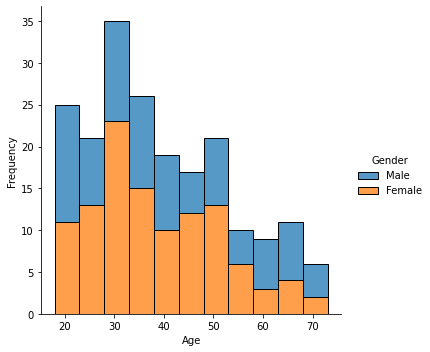

In [15]:
sns.displot(data=df, x="Age", hue="Gender", binwidth = 5, multiple = "stack");

plt.xlabel("Age")
plt.ylabel("Frequency")
#plt.xlim(18, 70)
plt.show()

Most of the customers are females.The age range of customers is between 18 and 70.

#### Annual Income Distribution

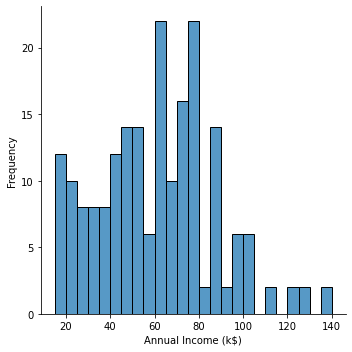

In [378]:
sns.displot(data=df, x="Annual Income (k$)", binwidth = 5);

plt.xlabel("Annual Income (k$)")
plt.ylabel("Frequency")
plt.show()

Annual Income between 60000 and 80000 dollars is more frequent among customers.

#### Spending Score Distribution

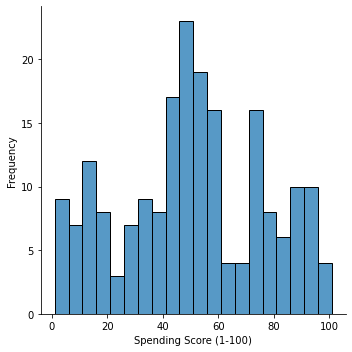

In [380]:
sns.displot(data=df, x="Spending Score (1-100)", binwidth = 5);

plt.xlabel("Spending Score (1-100)")
plt.ylabel("Frequency")
plt.show()

Most of the customers have a score of 50.

### Pairplot

Now lets plot a pairplot between different numeric features of dataset to find a pattern or any relation between them.

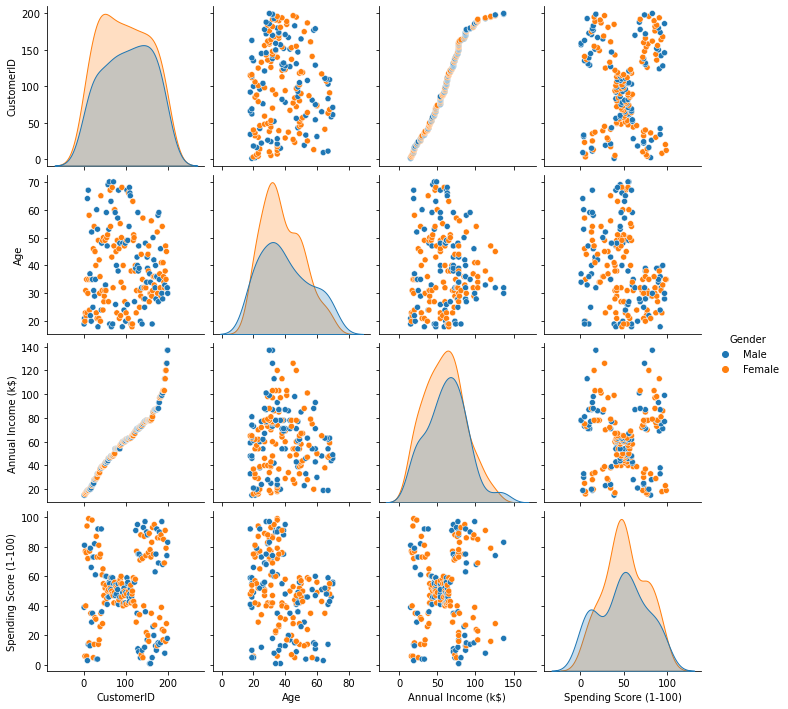

In [379]:
sns.pairplot(df, hue ='Gender')
plt.show()

In [381]:
df.corr()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,1.000000,-0.026763,0.977548,0.013835
Age,-0.026763,1.000000,-0.012398,-0.327227
Annual Income (k$),0.977548,-0.012398,1.000000,0.009903
Spending Score (1-100),0.013835,-0.327227,0.009903,1.000000


We can see that `CustomerID` and `Annual Income` have a very high correlation(0.977548).Becuase ID's are assigned to the customers according to their income.`Age` and `Spending Score` have a negative correlation(-0.327227). This means that as customer gets older , he or she is less inclined to buy things.

It looks like that, scatterplot between `Annual Income` and `Spending Score` separate data into five clusters.These two features show more obvious pattern than other features.

## KMeans clustering

In this section I use KMeans clustering.I only choose Annual Income (k$) and Spending Score (1-100) as scatter plots between other features do not show promising patterns.After dropping `CustomerID`, `Gender`, `Age` columns, we have to normalize features by using StandardScaler:

In [412]:
X = df.drop(['CustomerID', 'Gender', 'Age'] , axis = 1).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#X_scaled

In order to determine the optimal value of k(number of clusters), we have to use `Elbow` method. 

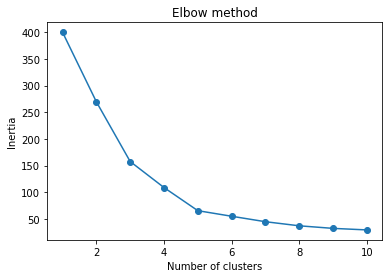

In [413]:
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

`Elbow` is the point after which the inertia start decreasing in a linear fashion. Thus for the our data, we conclude that the optimal k is 5. You can see our five clusters in the scatterplot.I plotted cluster centroid with red stars.

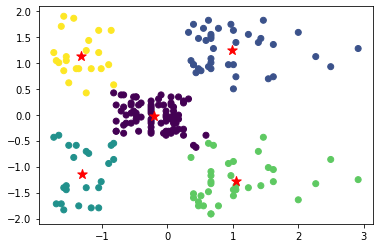

In [414]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_scaled)

#cmap = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'hsv']
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans.labels_, cmap = 'viridis')

cluster_centers_ = kmeans.cluster_centers_

#plot cluster centroid as stars
for k in range(len(cluster_centers_)):
    plt.scatter(kmeans.cluster_centers_[k][0], kmeans.cluster_centers_[k][1], color="r", marker="*", s= 100)

plt.show()

In order to evaluate clustering, I use two metrics:
- **Inertia**: It measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster.

- **Silhouette Score**: It measures the separation distance between clusters. It displays a measure of how close each point in a cluster is to points in the neighbouring clusters. This measure has a range of [-1, 1] .The Silhouette Score is calculated using the mean intra-cluster distance (i) and the mean nearest-cluster distance (n) for each sample. The Silhouette Coefficient for a sample is (n - i) / max(i, n).

The higher the Silhouette Coefficients (the closer to +1), the further away the cluster’s samples are from the neighbouring clusters samples. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighbouring clusters. Negative values, instead, indicate that those samples might have been assigned to the wrong cluster.

In [416]:
#evaluate clustering
print('inertia: %.3f' % kmeans.inertia_)

# Calculate Silhoutte Score
score = silhouette_score(X, kmeans.labels_, metric='euclidean')

# Print the score
print('Silhouette Score: %.3f' % score)

inertia: 65.568
Silhouette Score: 0.554


### Selecting All features

We can also use all of four features and compare the results.First convert `Gender` column type into numeric.

In [426]:
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

Now normalize the feature set(X2):

In [427]:
#X2 Contains all the features Gender, Age, Annual Income, Spending Score
X2 = df.drop('CustomerID', axis = 1).values

X2_scaled = scaler.fit_transform(X2)

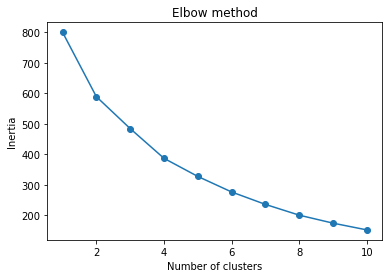

In [428]:
inertias2 = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X2_scaled)
    inertias2.append(kmeans.inertia_)

plt.plot(range(1,11), inertias2, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

This time our `Elbow` point is k = 8.

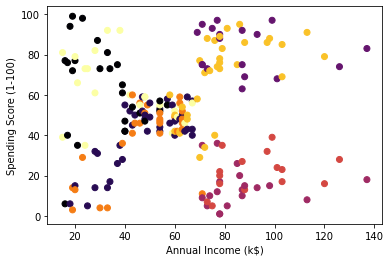

In [430]:
kmeans2 = KMeans(n_clusters=8)
kmeans2.fit(X2_scaled)

plt.scatter(X2[:, 2], X2[:, 3], c=kmeans2.labels_, cmap = 'inferno')
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.show()

In [431]:
#evaluate clustering
print('inertia: %.3f' % kmeans2.inertia_)

# Calculate Silhoutte Score
score2 = silhouette_score(X, kmeans2.labels_, metric='euclidean')

# Print the score
print('Silhouette Score: %.3f' % score2)

inertia: 205.942
Silhouette Score: -0.055


This time our inertia increases significantly(from 65 to 205) and Silhouette Score becomes negative. This shows us that a lot of points assigned to the wrong cluster and quality of our clusters degraded. So selecting all the features is not a good idea.

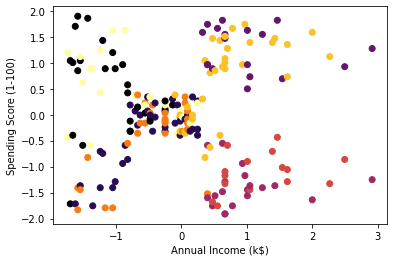

In [432]:
kmeans3 = KMeans(n_clusters=5)
kmeans3.fit(X2_scaled)

plt.scatter(X2_scaled[:, 2], X2_scaled[:, 3], c=kmeans2.labels_, cmap = 'inferno')
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.show()

In [433]:
#evaluate clustering
print('inertia: %.3f' % kmeans3.inertia_)

# Calculate Silhoutte Score
score3 = silhouette_score(X, kmeans3.labels_, metric='euclidean')

# Print the score
print('Silhouetter Score: %.3f' % score3)

inertia: 327.413
Silhouetter Score: -0.046


Even setting k = 5 does not make any improvement when we use all of four features.

## Agglomerative Clustering

Agglomerative Hierarchical Clustering is the bottom up approach.Hierarchical clustering requires us to decide on both a distance metric and linkage method. I will use euclidean, manhattan and cosine distance for affinity metric and two different linkage methods('average' and 'complete') and compare their silhouette scores.

In [435]:
# generates clusters using agglomerative clustering algorithm
# uses 'average' and 'complete' linkage method 
# with different affinity (metric) values: 'euclidean', 'manhattan' , 'cosine'
# 'ward' - Ward linkage method attempts to minimize the variance between clusters.
def agglom_clustering(features_data, num_clusters, metric, linkage_method = 'average'):
    cluster_model = AgglomerativeClustering(n_clusters=num_clusters,
                                            affinity=metric,
                                            linkage= linkage_method)
 
    clusters = cluster_model.fit_predict(features_data) #Fit and return the result of each sample's clustering assignment.

 
    score = silhouette_score(features_data,
                             cluster_model.labels_,
                             metric='euclidean')
    return clusters, score

First I use `average` linkage method with 3 different distance metrics.From Kmeans we know that best value for number of clusters is five.So I use 5 for `n_clusters`.

In [438]:
#Euclidean or L2 metric
y_euclidean, euclidean_score = agglom_clustering(X_scaled, 5, 'euclidean')

#Manhattan or L1 metric 
y_manhattan, manhattan_score = agglom_clustering(X_scaled, 5, 'manhattan')

#Cosine metric
y_cosine, cosine_score = agglom_clustering(X_scaled, 5, 'cosine')

print(f"Euclidean silhouette score is: {round(euclidean_score, 5)}")
print(f"Manhattan silhouette score is: {round(manhattan_score, 5)}")
print(f"Cosine silhouette score is: {round(cosine_score, 5)}")

Euclidean silhouette score is: 0.47943
Manhattan silhouette score is: 0.5511
Cosine silhouette score is: 0.30201


<BarContainer object of 3 artists>

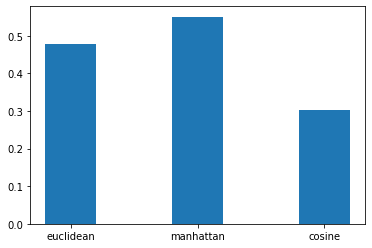

In [440]:
sil_scores = {'euclidean': euclidean_score,
                     'manhattan': manhattan_score,
                     'cosine': cosine_score}
plt.bar(list(sil_scores.keys()),
        list(sil_scores.values()),
        width=0.4)

We can see that `manhattan` distance metric or L1 norm has the highest silhouette score(0.5511) and Euclidean metric or L2 norm has a good performance too.But cosine metric performs poorly because it is not appropriate for low dimensional data.

In [441]:
# Plots the data after clustering
# y contains cluster labels for each data point
 
def plot_clusters(data, y, metric):
    plt.scatter(data[y==0, 0], data[y==0, 1],
                s=100, c='red',
                label ='Cluster 1')
    plt.scatter(data[y==1, 0], data[y==1, 1],
                s=100, c='blue',
                label ='Cluster 2')
    plt.scatter(data[y==2, 0], data[y==2, 1],
                s=100, c='green',
                label ='Cluster 3')
    plt.scatter(data[y==3, 0], data[y==3, 1],
                s=100, c='purple',
                label ='Cluster 4')
    plt.scatter(data[y==4, 0], data[y==4, 1],
                s=100, c='orange',
                label ='Cluster 5')
 
    plt.title(f'Customers Clustering (using {metric} distance metric)')
    plt.xlabel('Annual Income(k$)')
    plt.ylabel('Spending Score(1-100)')
    plt.legend()
    plt.show()

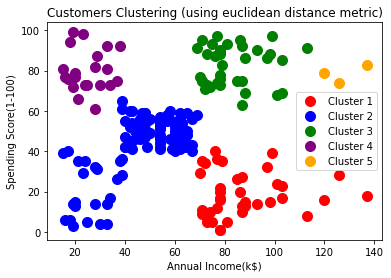

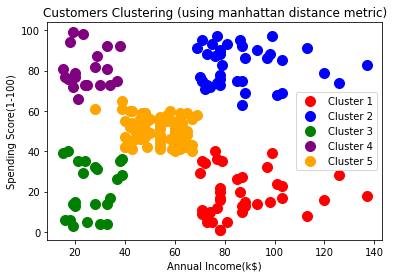

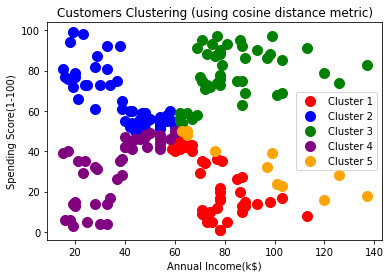

In [442]:
plot_clusters(X, y_euclidean, 'euclidean')
plot_clusters(X, y_manhattan, 'manhattan')
plot_clusters(X, y_cosine, 'cosine')

In order to visualize our clustering as a dendrogram, First I need to find the distance matrix.I use the distance_matrix function from scipy module and pass the Feature Matrix(X), as both inputs and save it to a variable called dist_matrix.

In [444]:
dist_matrix = distance_matrix(X,X) 
print(dist_matrix)

[[  0.          42.          33.01514804 ... 116.38728453 123.79418403
  129.69194269]
 [ 42.           0.          75.00666637 ... 111.22050171 137.3062271
  122.01639234]
 [ 33.01514804  75.00666637   0.         ... 129.32130528 121.59358536
  143.42245291]
 ...
 [116.38728453 111.22050171 129.32130528 ...   0.          57.07013229
   14.2126704 ]
 [123.79418403 137.3062271  121.59358536 ...  57.07013229   0.
   65.        ]
 [129.69194269 122.01639234 143.42245291 ...  14.2126704   65.
    0.        ]]


Then I make linkage by distance matrix and pass the linkage to dendrogram function of hierarchy class.By saving dendrogram to dendro, it will also be displayed.

In [445]:
Z = linkage(dist_matrix, 'average')

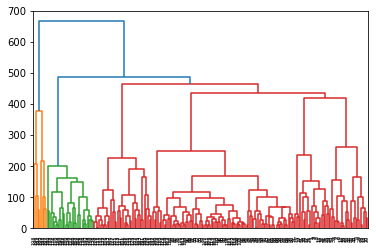

In [446]:
dendro = dendrogram(Z)

Now this time, I use `complete` linkage method.

In [450]:
#Euclidean or L2 metric
y_euclidean, euclidean_score = agglom_clustering(X_scaled, 5, 'euclidean', 'complete')

#Manhattan or L1 metric 
y_manhattan, manhattan_score = agglom_clustering(X_scaled, 5, 'manhattan', 'complete')

#Cosine metric
y_cosine, cosine_score = agglom_clustering(X_scaled, 5, 'cosine', 'complete')

print(f"Euclidean silhouette score is: {round(euclidean_score, 5)}")
print(f"Manhattan silhouette score is: {round(manhattan_score, 5)}")
print(f"Cosine silhouette score is: {round(cosine_score, 5)}")

Euclidean silhouette score is: 0.55311
Manhattan silhouette score is: 0.53918
Cosine silhouette score is: 0.28414


We can observe that for `complete` linkage Euclidean distance gives the highest silhouette score (0.55311).This value is higher than the best performance of `average` linkage (0.5511) from previous step.

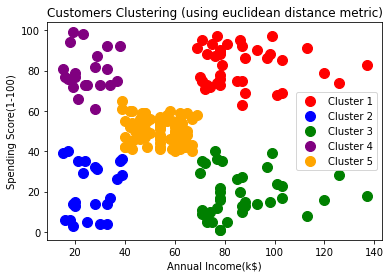

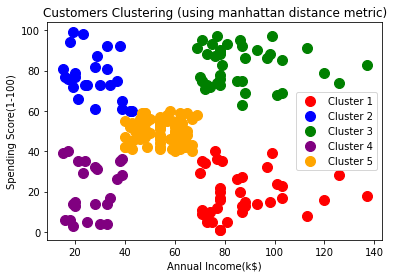

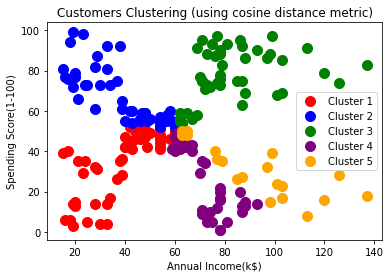

In [451]:
plot_clusters(X, y_euclidean, 'euclidean')
plot_clusters(X, y_manhattan, 'manhattan')
plot_clusters(X, y_cosine, 'cosine')

Lets plot dendrogram for complete linkage:

In [452]:
Z = linkage(dist_matrix, 'complete')

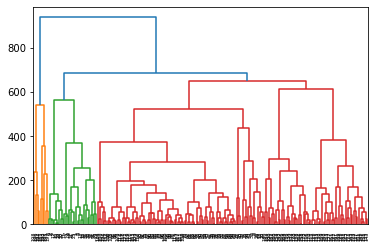

In [453]:
dendro = dendrogram(Z)

We saw that complete linkage with Euclidean distance metric gives the best silhouette score.Therefore I make an Agglomerative Clustering model with these parameters.

In [454]:
clustering = AgglomerativeClustering(n_clusters = 5, affinity='euclidean', linkage= 'complete').fit(X_scaled)
clustering.labels_

array([1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3,
       1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 4,
       1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0], dtype=int64)

The scatter plot below shows our five clusters that formed by agglomerative clustering:

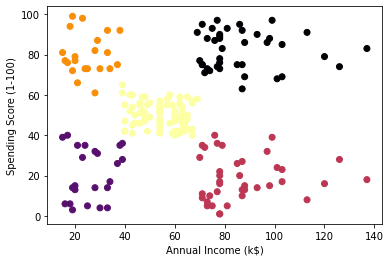

In [460]:
plt.scatter(X[:, 0], X[:, 1], c= clustering.labels_, cmap = 'inferno')
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.show()

In [461]:
score = silhouette_score(X_scaled, clustering.labels_, metric='euclidean')

score

0.5531118656926701

## Density Based Clustering

DBSCAN requires ε and minPts parameters for clustering. The minPts parameter is easy to set. The minPts should be 4 for two-dimensional dataset. For multidimensional dataset, minPts should be 2 * number of dimensions. For example, if your dataset has 6 features, set minPts = 12.In our example we have two features(`Annual Income`, `Spending Score`), we need minPts = 4.

In [517]:
db = DBSCAN(eps=0.36, min_samples=4).fit(X_scaled)

db.labels_
sc = silhouette_score(X_scaled, db.labels_)
print("Silhouette Coefficient:%0.2f"%sc)

Silhouette Coefficient:0.43


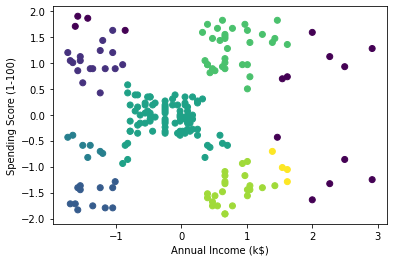

In [518]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c= db.labels_, cmap = 'viridis')
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.show()

In [467]:
sc = silhouette_score(X_scaled, db.labels_)
print("Silhouette Coefficient: %0.2f"%sc)

labels = db.labels_
  
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  
print(f"DBSCAN Number of clusters is : {n_clusters_}")

Silhouette Coefficient: 0.43
DBSCAN Number of clusters is : 7


In [468]:
from collections import Counter

Counter(db.labels_)

#plt.hist(db.labels_)

Counter({2: 7, 0: 17, 1: 12, -1: 15, 3: 89, 4: 33, 5: 23, 6: 4})

Text(0.5, 0, 'Cluster')

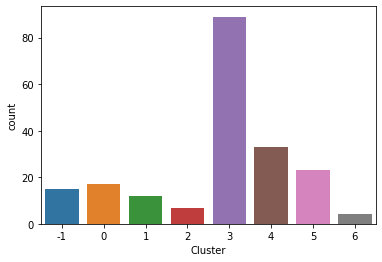

In [470]:
sns.countplot(db.labels_)

plt.xlabel("Cluster")

DBSCAN clustering identified 7 clusters with given parameters. The largest cluster (3) has 89 data points and the smallest cluster (6) has 4 data points.DBSCAN found 15 outliers.

### Find Epsilon Using Knee Method

The ε parameter is difficult to set and depends on the distance function. Sometimes, domain expertise is also required to set a ε parameter. To determine the optimal ε , I will compute the k-nearest neighbor (kNN) distances for each point in the dataset using the sklearn.neighbors.NearestNeighbors method.Number of neighbors parameter can be same as the min_samples value.

In [564]:
from sklearn.neighbors import NearestNeighbors
# n_neighbors = min_samples + 1 = 5 as kneighbors function returns distance of point to itself (first column will be zeros)
neighbors = NearestNeighbors(n_neighbors=5).fit(X_scaled)

# Find the k-neighbors of a point
neigh_dist, neigh_ind = neighbors.kneighbors(X_scaled)

# sort the distances of point to the neighbors in ascending order(axis = 0 means sort along row)
sort_neigh_dist = np.sort(neigh_dist, axis=0)

#neigh_dist[:,1:]
#neigh_dist
#sort_neigh_dist

Now, get the sorted kth column of distance matrix (distances with kth neighbors) and plot the kNN distance plot:

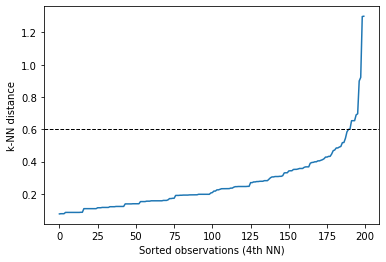

In [567]:
k_dist = sort_neigh_dist[:, 4]
plt.plot(k_dist)
plt.axhline(y=0.6, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

In [569]:
db = DBSCAN(eps=0.6, min_samples=4).fit(X_scaled)

db.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0, -1, -1, -1, -1], dtype=int64)

In [570]:
sc = silhouette_score(X_scaled, db.labels_)
print("Silhouette Coefficient:%0.2f"%sc)

labels = db.labels_
  
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  
print(n_clusters_)

Silhouette Coefficient:0.42
1


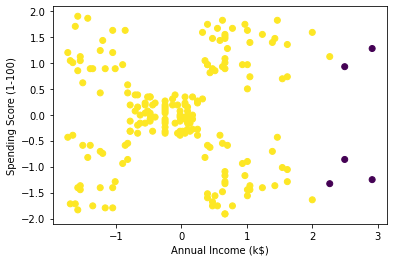

In [572]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c= db.labels_, cmap = 'viridis')
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.show()

Although Knee method gives us a good silhouette score(0.42), But we get only one cluster(yellow) and some noise(5 purple points).This is not consistent with what we know from Kmeans alorithm that we have 5 clusters.Because 0.6 is too big for epsilon.

This time lets use all the features(Gender, Age, Annual Income, Spending Score) which are normalized and stored in `X2_scaled`.Since we have 4 features, min_samples should be 2 X 4 = 8 . 

In [499]:
from sklearn.neighbors import NearestNeighbors
# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors=9).fit(X2_scaled)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(X2_scaled)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis=0)

#neigh_dist[:,1:]
#neigh_dist

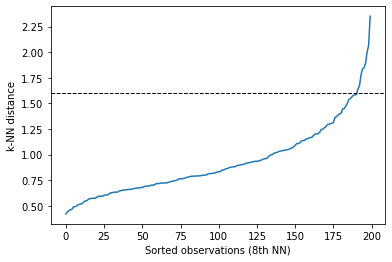

In [500]:
k_dist = sort_neigh_dist[:, 8]
plt.plot(k_dist)
plt.axhline(y=1.6, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (8th NN)")
plt.show()

We can see that the knee occurs at approximately 1.6 .The points below 1.6 belong to a cluster and points above it are noise or outliers. We pass these values in the DBSCAN function of sklearn module.

In [501]:
db2 = DBSCAN(eps=1.6, min_samples=8).fit(X2_scaled)

db2.labels_

array([0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0], dtype=int64)

In [502]:
sc = silhouette_score(X2_scaled, db2.labels_)
print("Silhouette Coefficient:%0.2f"%sc)

labels = db2.labels_
  
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  
print(n_clusters_)

Silhouette Coefficient:0.28
2


We can observe that when we use more features for clustering, silhouette coefficient decreases.You can see clustering plot in the chart below. We have two clusters(yellow and green).Purple points are outliers.

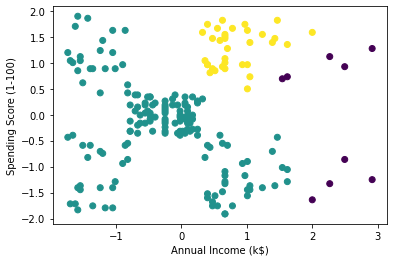

In [516]:
plt.scatter(X2_scaled[:, 2], X2_scaled[:, 3], c= db2.labels_, cmap = 'viridis')
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.show()